In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import sys

# Data generation

In [2]:
data = utils.generate_sample(n_components=2, n_points=2000, random_seed=42)

# Data display

Component 0


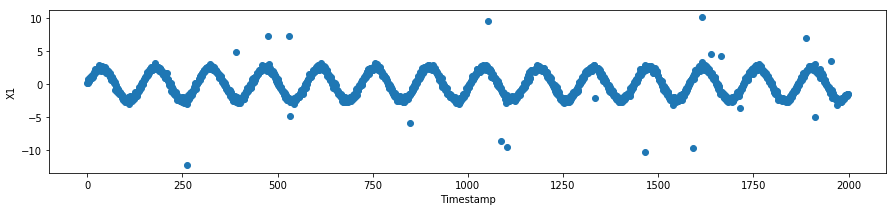

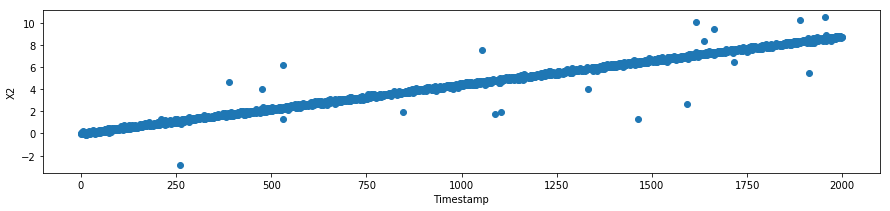

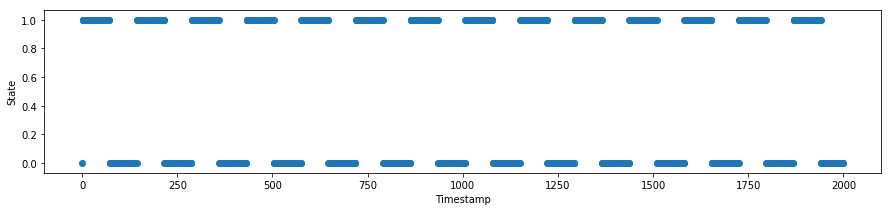

Component 1


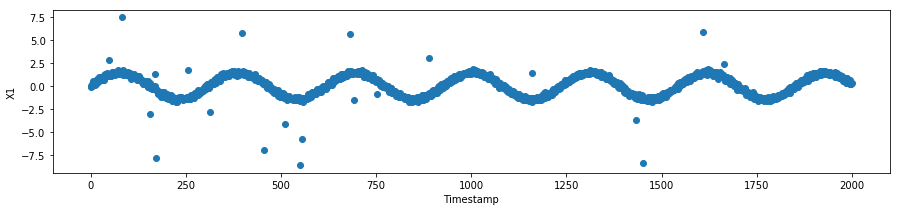

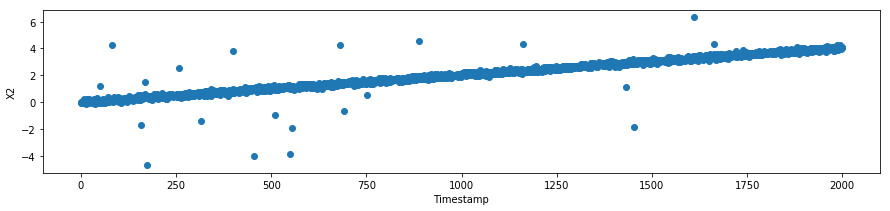

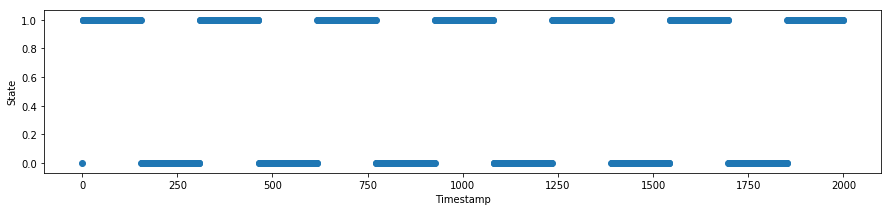

In [3]:
for acomp in data.keys():
    
    data_comp = data[acomp]
    print(acomp)
    
    columns = data_comp.columns[1:]
    for acol in columns:
        plt.figure(figsize=(15, 3))
        plt.scatter(data_comp['Timestamp'].values, data_comp[acol].values)
        plt.xlabel('Timestamp')
        plt.ylabel(acol)
        plt.show()

# Preprocessing

In [4]:
sys.path.append('../nostradamus')
import preprocessing

Component 0


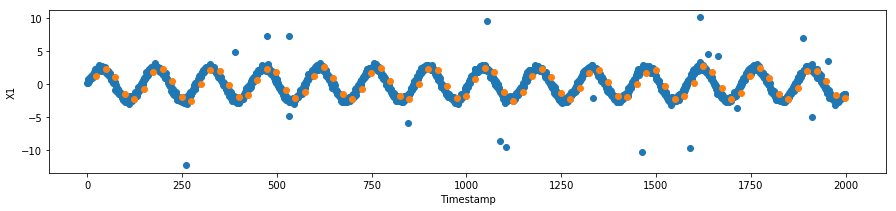

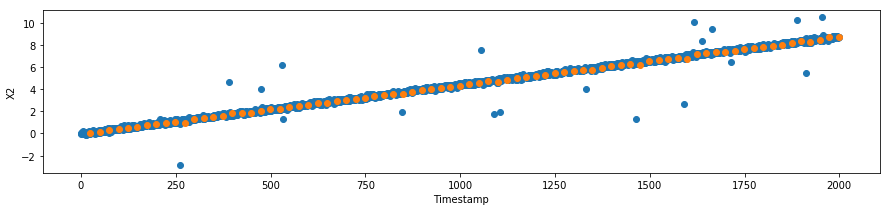

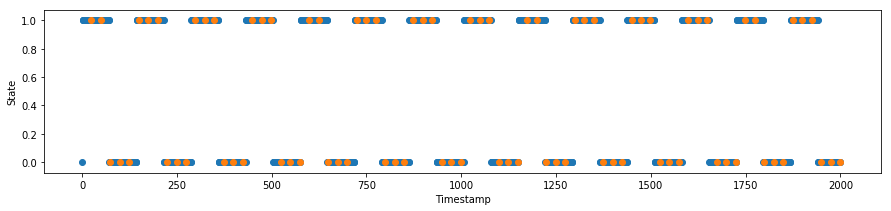

Component 1


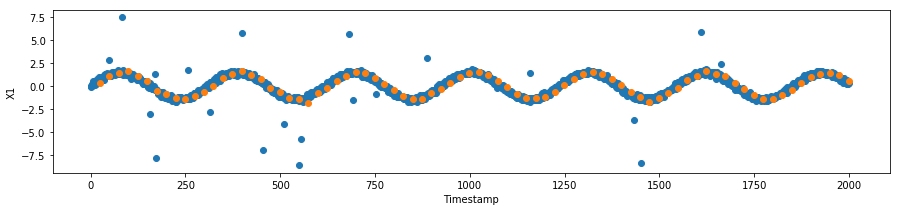

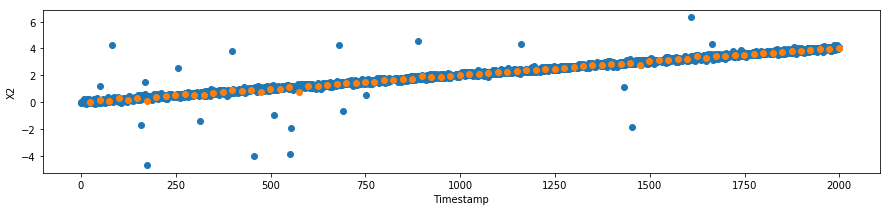

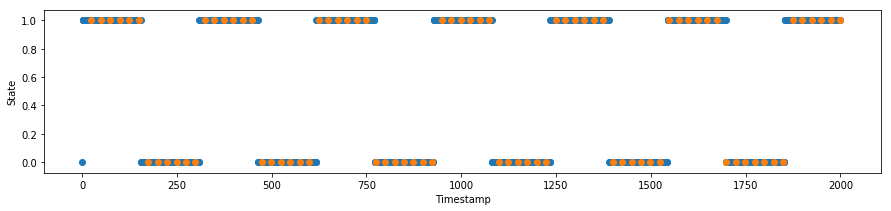

In [5]:
for acomp in data.keys():
    
    data_comp = data[acomp]
    print(acomp)
    
    columns = data_comp.columns[1:]
    for acol in columns:
        plt.figure(figsize=(15, 3))
        
        timestamps = data_comp['Timestamp'].values
        x = data_comp[acol].values
        plt.scatter(timestamps, x)
        
        if acol != 'State':
            x_agg, timestamps_agg = preprocessing.time_aggregation(timestamps, x.reshape(-1, 1), 25, 'mean')
        else:
            x_agg, timestamps_agg = preprocessing.time_aggregation(timestamps, x.reshape(-1, 1), 25, 'last')
        plt.scatter(timestamps_agg, x_agg)
        
        plt.xlabel('Timestamp')
        plt.ylabel(acol)
        plt.show()

In [6]:
X = data['Component 0'][['X1', 'X2']].values[:5]
X_slices = preprocessing.slicer(X, slice_size=2)

In [7]:
X

array([[ 0.12408717,  0.04967142],
       [ 0.07461572, -0.00945557],
       [ 0.37990721,  0.07351058],
       [ 0.70711276,  0.16541557],
       [ 0.37604752, -0.00593189]])

In [8]:
X_slices

array([[ 0.12408717,  0.04967142,  0.07461572, -0.00945557],
       [ 0.07461572, -0.00945557,  0.37990721,  0.07351058],
       [ 0.37990721,  0.07351058,  0.70711276,  0.16541557],
       [ 0.70711276,  0.16541557,  0.37604752, -0.00593189]])

In [9]:
X_shifted = preprocessing.shifter(X, shift_size=2)

In [10]:
X_shifted

array([[ 0.37990721,  0.07351058],
       [ 0.70711276,  0.16541557],
       [ 0.37604752, -0.00593189]])

In [11]:
X = np.array([['A', 1., 'AA'], ['B', 2, 'BB'], ['A', 1, 'BB']], dtype=object)
Y = np.array([['B', 1, 'AA'], ['B', 5, 'BB'], ['A', 3, 'AA']], dtype=object)

ce = preprocessing.CategoryEncoder()
ce.fit(X)

In [12]:
ce.transform(Y)

array([[1, 0.0, 1.0, 1.0, 0.0],
       [5, 0.0, 1.0, 0.0, 1.0],
       [3, 1.0, 0.0, 1.0, 0.0]], dtype=object)

# Failures Prediction

In [13]:
import failures

def _train_test_split(X, y=None, test_size=0.5):
        """
        Split data on train and test samples.

        Parameters
        ----------
        X : array-like
            Input features used for prediction.
        y : array-like
            Target to predict.
        test_size : float in [0, 1] range
            Fraction of test sample.

        Returns
        -------
        X_train, X_test, y_train, y_test : array-like
            Train and test samples.
        """

        x_size = len(X)
        cut = int(np.round((1 - test_size) * x_size))
        X_train, X_test = X[cut:], X[:cut]
        if y is not None:
            y_train, y_test = y[cut:], y[:cut]
            return X_train, X_test, y_train, y_test
        else:
            return X_train, X_test

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

fail = failures.FailurePredictor(classifier=clf, window_size=10, slice_size=5, prediction_horizont=5)

In [15]:
X = data['Component 1'][['X1', 'X2']].values
y = data['Component 1']['State'].values
timestamps = data['Component 1']['Timestamp'].values

X_train, X_test, timestamps_train, timestamps_test = _train_test_split(X, timestamps, test_size=0.5)
y_train, y_test = _train_test_split(y, test_size=0.5)

fail.fit(timestamps_train, X_train, y_train)

In [16]:
times, failure_probas, health_states = fail.predict(timestamps_test, X_test)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


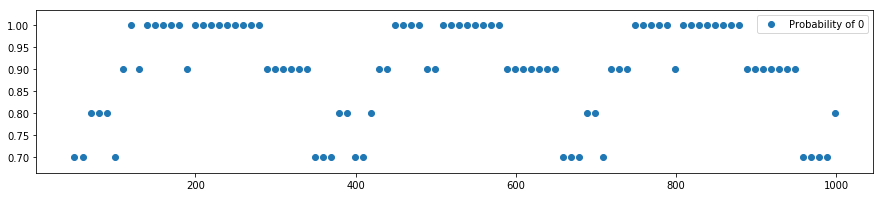

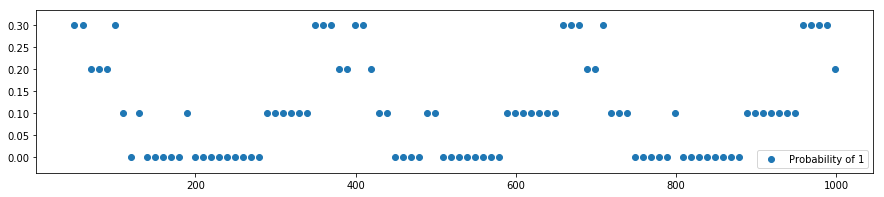

In [17]:
for i in range(failure_probas.shape[1]):
    plt.figure(figsize=(15, 3))
    proba = failure_probas[:, i]
    plt.scatter(times, proba, label='Probability of '+str(i))
    plt.legend(loc='best')
    plt.show()

# Jarvis

In [18]:
X = data['Component 1'][['X1', 'X2']].values
y = data['Component 1']['State'].values
timestamps = data['Component 1']['Timestamp'].values

X_train, X_test, timestamps_train, timestamps_test = _train_test_split(X, timestamps, test_size=0.5)
y_train, y_test = _train_test_split(y, test_size=0.5)

In [19]:
import classifiers

jarvis = classifiers.JarvisClassifier(verbose=2)
#jarvis.fit(X_test, y_test)

Using Theano backend.


In [20]:
#jarvis.best_estimator

In [21]:
fail = failures.FailurePredictor(classifier=jarvis, window_size=10, slice_size=5, prediction_horizont=5)
fail.fit(timestamps_train, X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] max_depth=3, max_features=None, min_samples_leaf=1 ..............
[CV] max_depth=3, max_features=None, min_samples_leaf=1 ..............
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, total=   1.7s
[CV] max_depth=3, max_features=None, min_samples_leaf=1 ..............
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, total=   1.7s
[CV] max_depth=3, max_features=None, min_samples_leaf=10 .............
[CV]  max_depth=3, max_features=None, min_samples_leaf=10, total=   1.3s
[CV] max_depth=3, max_features=None, min_samples_leaf=10 .............
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, total=   1.4s
[CV] max_depth=3, max_features=None, min_samples_leaf=10 .............
[CV]  max_depth=3, max_features=None, min_samples_leaf=10, total=   1.3s
[CV] max_depth=3, max_features=None, min_samples_leaf=50 .............
[CV]  max_depth=3, max_features=None, min_samples_leaf=10, total=   1.3s
[CV] ma

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   29.2s


[CV]  max_depth=6, max_features=auto, min_samples_leaf=10, total=   1.5s
[CV] max_depth=6, max_features=auto, min_samples_leaf=10 .............
[CV]  max_depth=6, max_features=auto, min_samples_leaf=1, total=   1.5s
[CV] max_depth=6, max_features=auto, min_samples_leaf=10 .............
[CV]  max_depth=6, max_features=auto, min_samples_leaf=10, total=   1.5s
[CV]  max_depth=6, max_features=auto, min_samples_leaf=10, total=   1.5s
[CV] max_depth=6, max_features=auto, min_samples_leaf=50 .............
[CV] max_depth=6, max_features=auto, min_samples_leaf=50 .............
[CV]  max_depth=6, max_features=auto, min_samples_leaf=50, total=   1.8s
[CV] max_depth=6, max_features=auto, min_samples_leaf=50 .............
[CV]  max_depth=6, max_features=auto, min_samples_leaf=50, total=   1.8s
[CV] max_depth=6, max_features=0.8, min_samples_leaf=1 ...............
[CV]  max_depth=6, max_features=auto, min_samples_leaf=50, total=   1.5s
[CV] max_depth=6, max_features=0.8, min_samples_leaf=1 .........

[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  1.1min finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] C=5 .............................................................
[CV] C=5 .............................................................
[CV] .............................................. C=5, total=   0.0s
[CV] .............................................. C=5, total=   0.0s
[CV] C=5 .............................................................
[CV] .............................................. C=2, total=   0.0s
[CV] .............................................. C=5, total=   0.0s
[CV] C=2 .............................................................
[CV] C=0.1 ...........................................................
[CV] C=2 .............................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] .............................................. C=2, total=   0.0s
[CV] C=2 ........

[Parallel(n_jobs=2)]: Done  21 out of  21 | elapsed:    0.2s finished


[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, total=   0.1s
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.1, max_de

[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=10 
[CV]  colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=10 
[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, total=   0.1s
[CV] colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=

[CV] colsample_bytree=1, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, learning_rate=0.1, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=1, learning_rate=0.1, max_depth=8, min_child_weight=10 
[CV]  colsample_bytree=1, learning_rate=0.05, max_depth=3, min_child_weight=1, total=   0.1s
[CV] colsample_bytree=1, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, learning_rate=0.1, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=1, learning_rate=0.1, max_depth=8, min_child_weight=10 
[CV]  colsample_bytree=1, learning_rate=0.05, max_depth=3, min_child_weight=1, total=   0.1s
[CV] colsample_bytree=1, learning_rate=0.05, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=1, learning_rate=0.1, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=1, learning_rate=0.05, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=1, learning_rate=0.05, max_depth=3, min_ch

[CV]  colsample_bytree=1, learning_rate=0.01, max_depth=8, min_child_weight=10, total=   0.1s
[CV] colsample_bytree=1, learning_rate=0.01, max_depth=8, min_child_weight=10 
[CV]  colsample_bytree=1, learning_rate=0.01, max_depth=8, min_child_weight=10, total=   0.1s


[Parallel(n_jobs=2)]: Done 144 out of 144 | elapsed:    7.2s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] hidden_dim=10 ...................................................
[CV] hidden_dim=10 ...................................................
[CV] .................................... hidden_dim=10, total=   5.0s
[CV] hidden_dim=10 ...................................................
[CV] .................................... hidden_dim=10, total=   0.9s
[CV] hidden_dim=30 ...................................................
[CV] .................................... hidden_dim=30, total=   0.8s
[CV] hidden_dim=30 ...................................................
[CV] .................................... hidden_dim=30, total=   0.8s
[CV] hidden_dim=30 ...................................................
[CV] .................................... hidden_dim=30, total=   0.8s
[CV] hidden_dim=100 ..................................................
[CV] ................................... hidden_dim=100, total=   0.9s
[CV] hidden_dim=10

[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:   13.5s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] dropout=0, hidden_dim=10, n_hidden_layers=2 .....................
[CV] dropout=0, hidden_dim=10, n_hidden_layers=2 .....................
[CV] ...... dropout=0, hidden_dim=10, n_hidden_layers=2, total=   2.9s
[CV] dropout=0, hidden_dim=10, n_hidden_layers=2 .....................
[CV] ...... dropout=0, hidden_dim=10, n_hidden_layers=2, total=   1.7s
[CV] dropout=0, hidden_dim=10, n_hidden_layers=3 .....................
[CV] ...... dropout=0, hidden_dim=10, n_hidden_layers=3, total=   2.7s
[CV] dropout=0, hidden_dim=10, n_hidden_layers=3 .....................
[CV] ...... dropout=0, hidden_dim=10, n_hidden_layers=2, total=   9.7s
[CV] dropout=0, hidden_dim=10, n_hidden_layers=3 .....................
[CV] ...... dropout=0, hidden_dim=10, n_hidden_layers=3, total=   2.8s
[CV] dropout=0, hidden_dim=10, n_hidden_layers=4 .....................
[CV] ...... dropout=0, hidden_dim=10, n_hidden_layers=3, total=   3.2s
[CV] dropout=0, 

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.2min


[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=2, total=   2.5s
[CV] dropout=0.1, hidden_dim=30, n_hidden_layers=3 ...................
[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=2, total=   2.5s
[CV] dropout=0.1, hidden_dim=30, n_hidden_layers=3 ...................
[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=3, total=   3.9s
[CV] dropout=0.1, hidden_dim=30, n_hidden_layers=3 ...................
[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=3, total=   4.0s
[CV] dropout=0.1, hidden_dim=30, n_hidden_layers=4 ...................
[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=3, total=   4.0s
[CV] dropout=0.1, hidden_dim=30, n_hidden_layers=4 ...................
[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=4, total=   5.3s
[CV] dropout=0.1, hidden_dim=30, n_hidden_layers=4 ...................
[CV] .... dropout=0.1, hidden_dim=30, n_hidden_layers=4, total=   5.5s
[CV] dropout=0.1, hidden_dim=100, n_hidden_layers=2 ..................
[CV] .

[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  2.7min finished


In [22]:
times, failure_probas, health_states = fail.predict(timestamps_test, X_test)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


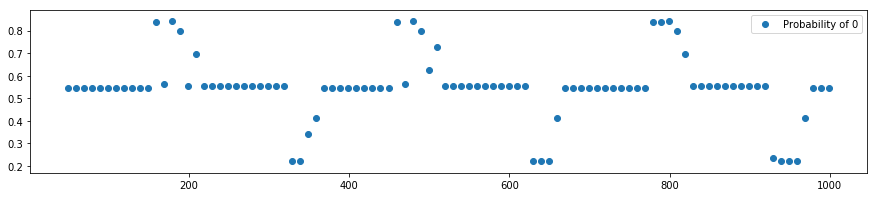

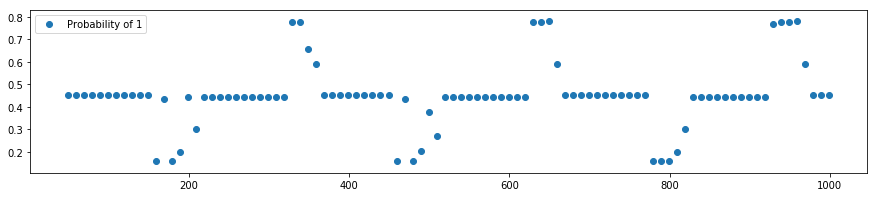

In [23]:
for i in range(failure_probas.shape[1]):
    plt.figure(figsize=(15, 3))
    proba = failure_probas[:, i]
    plt.scatter(times, proba, label='Probability of '+str(i))
    plt.legend(loc='best')
    plt.show()

In [24]:
fail.classifier.best_estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# NN

In [25]:
nn = classifiers.KerasOneLayerNN()
nn.fit(X_train, y_train)

In [26]:
p = nn.predict_proba(X_test)
p[:5]

array([[0.26867327, 0.73132676],
       [0.55549777, 0.4445022 ],
       [0.32875955, 0.67124045],
       [0.31591663, 0.68408334],
       [0.06418854, 0.93581146]], dtype=float32)

In [27]:
nn = classifiers.KerasDeepNN()
nn.fit(X_train, y_train)

p = nn.predict_proba(X_test)
p[:5]

array([[0.10400372, 0.8959963 ],
       [0.16149938, 0.8385006 ],
       [0.11466582, 0.8853342 ],
       [0.11276037, 0.88723963],
       [0.05849388, 0.94150615]], dtype=float32)

# Train

In [28]:
import instruments

In [29]:
train = instruments.FortuneWheel(method='Jarvis')
train.fit(data)
train.save_model('model.pkl')

In [30]:
train.model

{'Component 0': {'failure_predictor': <failures.FailurePredictor at 0x1037d12e8>,
  'input_columns': ['X1', 'X2']},
 'Component 1': {'failure_predictor': <failures.FailurePredictor at 0x10e9bdb00>,
  'input_columns': ['X1', 'X2']}}

# Predict

In [31]:
import instruments

In [32]:
pred = instruments.CrystalBall()
pred.load_models('model.pkl')
output = pred.predict(data)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [33]:
output['Component 0'].head()

0         1  Timestamp
0  0.028426  0.971574         99
1  0.001284  0.998716        109
2  0.000334  0.999666        119
3  0.000170  0.999830        129
4  0.000087  0.999913        139

# Setup

In [34]:
import nostradamus
from nostradamus.instruments import CrystalBall, FortuneWheel
from nostradamus.failures import FailurePredictor